In [1]:
import numpy as np
from matplotlib import pyplot as plt

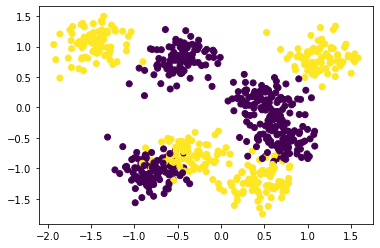

In [2]:
from script import make_dataset
x, y = make_dataset()

Epoch:  0 | train loss: 0.2570
Epoch:  200 | train loss: 0.0922
Epoch:  400 | train loss: 0.0911
Epoch:  600 | train loss: 0.0906
Epoch:  800 | train loss: 0.0903
Epoch:  1000 | train loss: 0.0901
Epoch:  1200 | train loss: 0.0900
Epoch:  1400 | train loss: 0.0899
Epoch:  1600 | train loss: 0.0899
Epoch:  1800 | train loss: 0.0898


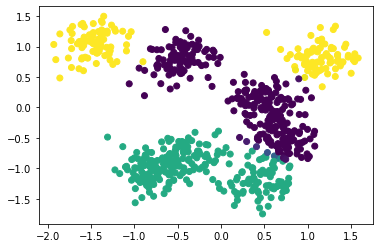

In [3]:
from script import make_model
model = make_model(x, y)

In [62]:
def relu(x):
    x *= x > 0
    return x


class Layer:
    def __init__(self, w, b, abst_func=lambda x: np.floor(relu(x))):
        self.W = w
        self.U = np.array([0 for i in range(self.W.shape[0])]).astype('float64')
        self.b = b
        self.N = self.U.copy()*0
        self.abs_func = abst_func

        self.history_U = [self.U.copy()]
        self.history_S = [self.N.copy()]

    def reset(self):
        self.U = np.array([0 for i in range(self.W.shape[0])]).astype('float64')
        self.N = self.U.copy()

        # self.history_U = [self.U.copy()]
        # self.history_S = [self.N.copy()]

    def forward(self, inp):
        x, spiked = self.simulate(inp)
        self.history_U.append(self.U.copy())
        self.history_S.append(spiked.copy())
        if (self.U>1.01).any() and type(self) is Layer: print(self.U)
        return x

    def simulate(self, inp):
        self.U += np.dot(self.W, inp) + self.b
        spiked = self.U >= 1
        return self.neuron_func(spiked), spiked

    def neuron_func(self, spiked):
        if not spiked.any(): return spiked
        self.N += spiked
        self.U[spiked] -= 1
        return spiked

    def abstract_n(self, inp, t):
        if len(np.array(inp).shape) == 2:
            return np.array([self.abstract_n(xx, t) for xx in inp])
        return self.abs_func(np.dot(self.W, inp) + self.b * t)

    def abstract_v(self, inp, t):
        if len(np.array(inp).shape) == 2:
            return np.array([self.abstract_v(xx, t) for xx in inp])
        return self.W[inp].sum(axis=1) + self.b * t - self.abstract_n(inp, t)

    def plot_history(self, lim, ylim=None):
        plt.rcParams['figure.figsize'] = (20, 10)
        plt.step(np.arange(len(self.history_U)), self.history_U, label='U', where='post')
        plt.scatter(np.arange(len(self.history_S)), np.array(self.history_S).sum(axis=1) * 3 - 2, label='S')
        plt.ylim(-0.1, max(np.max(self.history_U) + 0.1, 1.1))
        plt.xlim(0, lim)
        plt.grid()
        plt.show()

        history_N = [np.array(self.history_S[:tt+1]).sum(axis=0) for tt in range(len(self.history_S))]
        plt.rcParams['figure.figsize'] = (20, 10)
        plt.step(np.arange(len(self.history_S)), np.array(history_N), label='N', where='post')
        if ylim is not None: plt.ylim(-0.1, ylim)
        plt.xlim(0, lim)
        plt.grid()
        plt.show()


class AlterLayer(Layer):
    def neuron_func(self, spiked):
        if not spiked.any(): return spiked
        output = spiked * (self.U // 1)
        self.N += output
        self.U[spiked] %= 1
        return output


class OutLayer(Layer):
    def __init__(self, *args, **kwargs):
        super(OutLayer, self).__init__(abst_func=lambda x: x, *args, **kwargs)

    def neuron_func(self, spiked):
        self.N += self.U.copy()
        return self.U.copy()


class SNN:
    def __init__(self, w, b, fin_act=lambda x: x, layer_type=Layer):
        self.layers = [layer_type(w[m], b[m]) for m in range(len(w) - 1)] + [OutLayer(w[-1], b[-1])]
        self.final_activation = fin_act

    def reset(self):
        for l in self.layers: l.reset()

    def __call__(self, x, t=1):
        if len(x.shape) == 1:
            out = self.predict(x, t).copy()
            self.reset()
            return out
        if len(x.shape) != 2: raise ValueError('x must be a vector or 2D matrix')

        out = []
        for i in range(x.shape[0]):
            out.append(self.predict(x[i], t).copy())
            self.reset()
        return np.array(out)

    def forward(self, x):
        layer_out = x.copy()
        for i, l in enumerate(self.layers):
            # print(i, layer_out)
            layer_out = l.forward(layer_out)
        return layer_out

    def predict(self, x, t):
        for _ in range(t): self.forward(x.copy())
        return self.final_activation(self.layers[-1].N / t)

    def abstract_n_layer(self, x, t, lim):
        x = x * t
        for l in self.layers[:lim+1]: x = l.abstract_n(x.copy(), t)
        return x

    def abstract_n(self, x, t):
        return self.final_activation(self.abstract_n_layer(x, t, len(self.layers)) / t)

    def abstract_v_layer(self, x, t, lim):
        for l in self.layers[:lim]: x = l.abstract_v(x.copy() * t, t)
        return x

    def abstract_v(self, x, t):
        return self.final_activation(self.abstract_v_layer(x, t, len(self.layers)) / t)

In [65]:
from script import get_changed_weight,torch

w = list(model.parameters())
wb = [[w[i].data.numpy().copy() for i in range(0, len(w), 2)],
      [w[i].data.numpy().copy() for i in range(1, len(w), 2)]]

wb, (a,b)=get_changed_weight(x,wb,model)
snn_model=SNN(wb[0],wb[1],fin_act=lambda x:1/(1+np.exp(-x)),layer_type=Layer)

# snn_model=SNN(wb[0],wb[1],fin_act=lambda x:1/(1+np.exp(-x)),layer_type=AlterLayer)

xx = x.astype('float64')[5]
t = 1000
print(model(torch.from_numpy(xx.copy()).float()).data.numpy() * 1000//1/1000)
print(snn_model(xx, t) * 1000//1/1000)
print(snn_model.abstract_n(xx, t) * 1000//1/1000)

[1. 0.]
[1. 0.]
[1. 0.]


C:\Users\Hossein\AppData\Local\Temp/ipykernel_14516/3847379858.py:8: RuntimeWarning: overflow encountered in exp
  snn_model=SNN(wb[0],wb[1],fin_act=lambda x:1/(1+np.exp(-x)),layer_type=Layer)


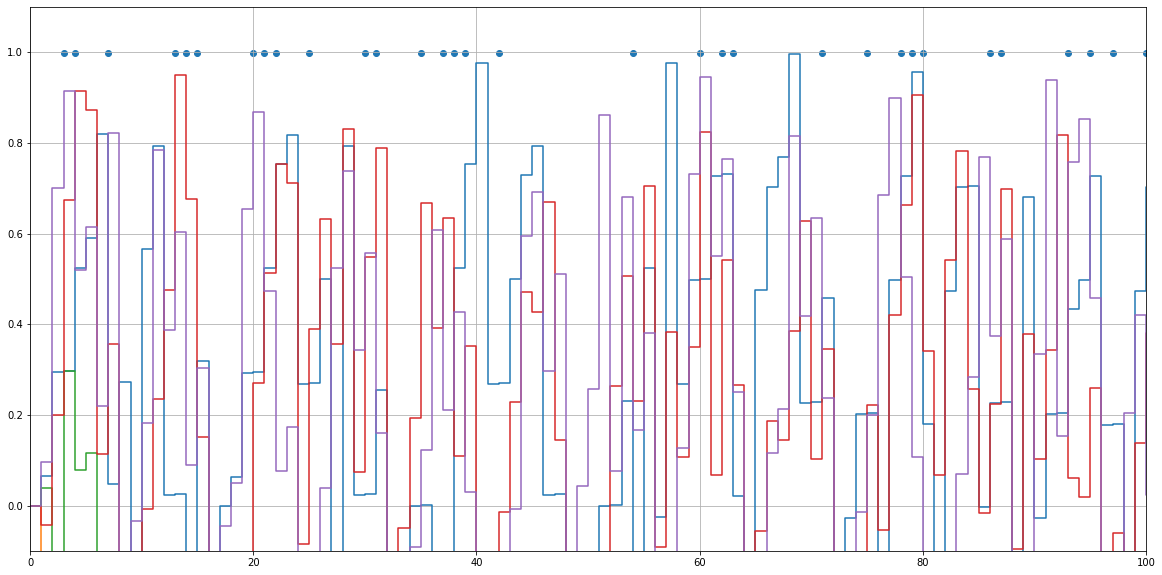

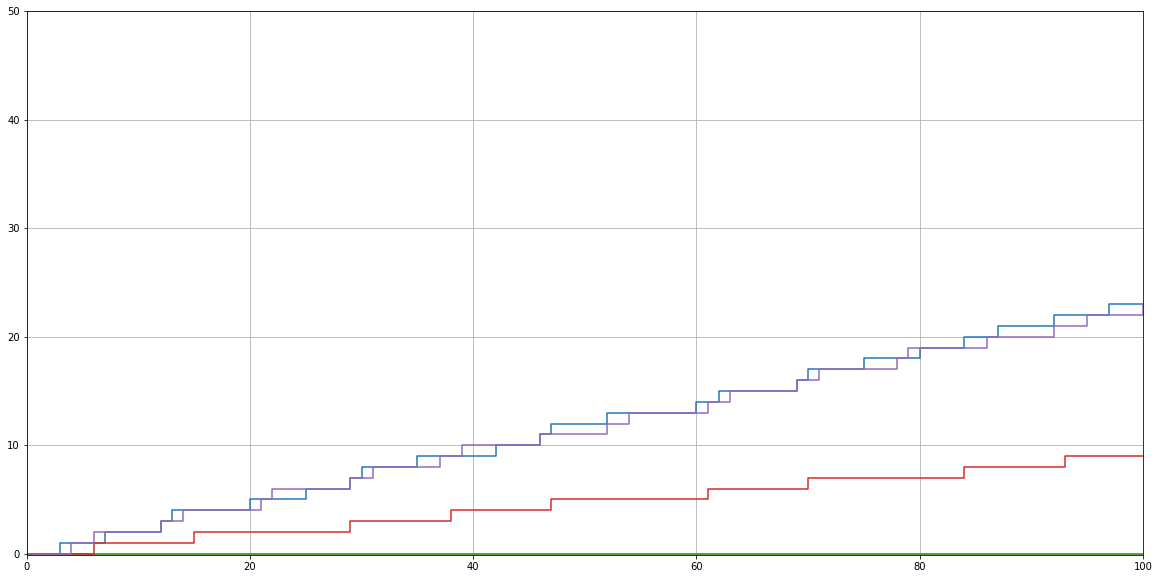

In [69]:
snn_model.layers[1].plot_history(100, 50)

(0.0, 100.0)

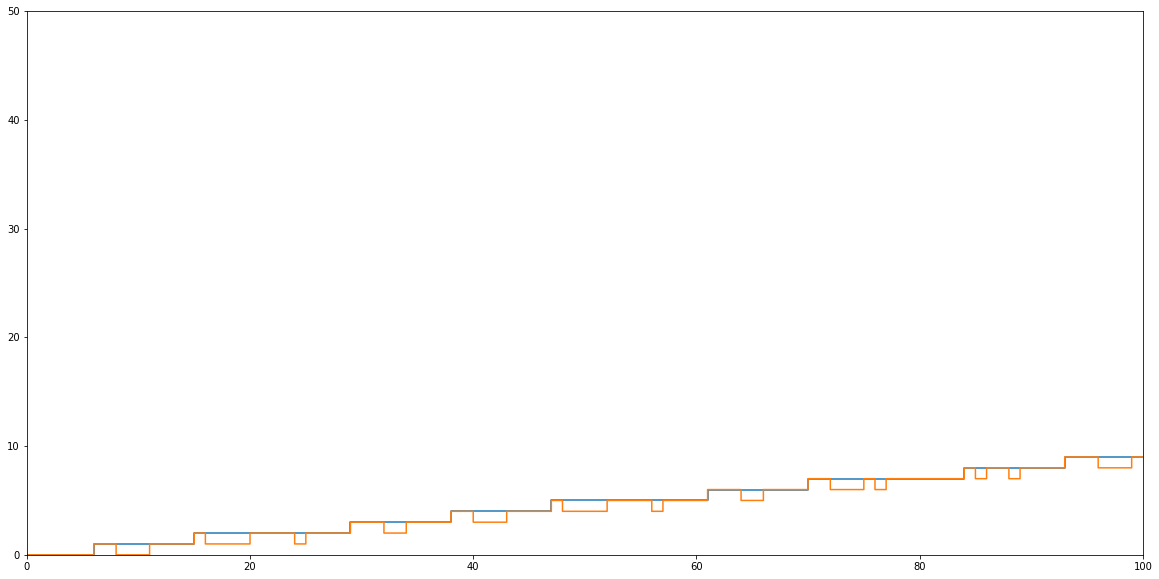

In [75]:
lay=1;neu=3

real_n=np.array(snn_model.layers[lay].history_S).T[neu]
plt.step(np.arange(len(real_n)), [real_n[:i+1].sum() for i in range(len(real_n))], where='post')

abs_n=np.array([snn_model.abstract_n_layer(xx,tt,lay) for tt in range(t)]).T[neu]
plt.step(np.arange(len(abs_n)), abs_n, where='post')

plt.ylim(0,50)
plt.xlim(0,100)

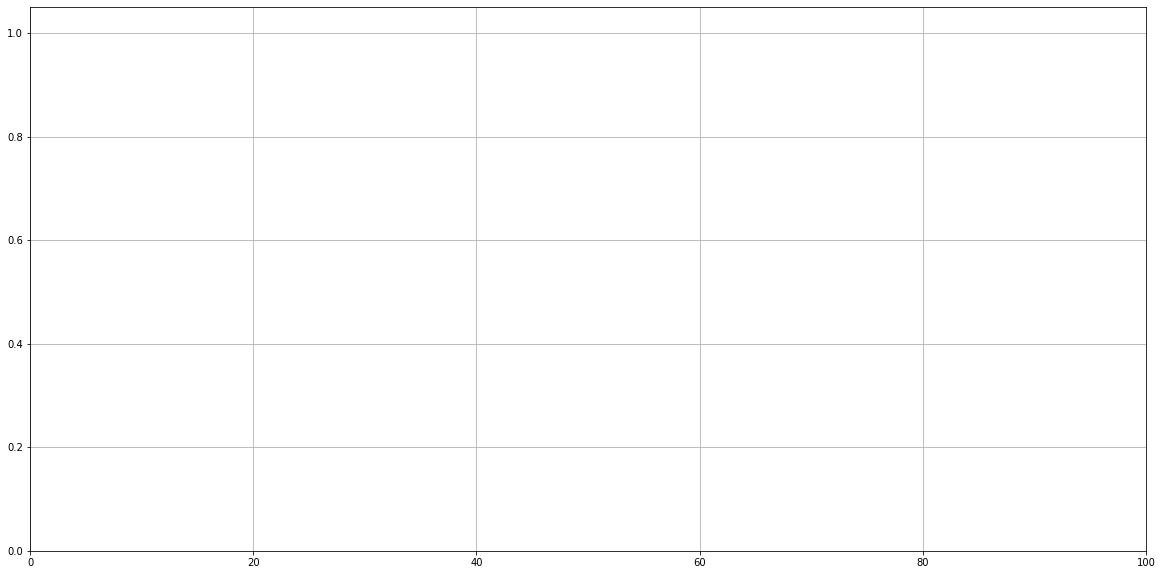

In [12]:
ll=0;ln=3
l_h_u=np.array(snn_model.layers[ll].history_U[1:])
h_s=l_h_u.copy()
br=22
sub_h_s=l_h_u[0:br].copy()
for i in np.arange(br,t,br):
    h_s[i-br:i]-=sub_h_s

layer=snn_model.layers[0]; x_lim=100
plt.rcParams['figure.figsize'] = (20, 10)
plt.step(np.arange(len(h_s)), list(zip(h_s,l_h_u)), label='S')
plt.step(np.arange(len(list(sub_h_s)*(t//br))),list(sub_h_s)*(t//br))
plt.xlim(0,x_lim)
plt.ylim(0,1.05)
plt.grid()
plt.show()

In [8]:
def fft_u(y,t):
    from scipy.fftpack import fft
    # Number of sample points
    N = t
    # sample spacing
    T = 1.0
    x = np.arange(N)
    yf = fft(y,)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    import matplotlib.pyplot as plt
    plt.rcParams['figure.figsize'] = (30, 10)
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.grid()
    plt.ylim(0,0.25)
    plt.show()
fft_u(np.array(snn_model.layers[3].history_U[1:])[:,3],t)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed